In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import curvedsky as cs
import binning

In [2]:
sys.path.append('../')

In [3]:
%load_ext autoreload
%autoreload 2
from lbxs4.cmb import CMBLensed
from lbxs4.simulations import LBSky,S4Sky
from lbxs4.filtering import FiltCoadd
from lbxs4.multitracer import CoaddKappa
from lbxs4.delensing import Delenser
from lbxs4.config import *

In [4]:
cmb = CMBLensed()

In [5]:
teb_input = cmb.TEB(0)

In [6]:

lb_sky = LBSky(512)
s4_sky = S4Sky()

In [62]:
mask = lb_sky.nilc_mask  *  hp.ud_grade(s4_sky.nilc_mask,512)

In [64]:
lbelm = hp.map2alm(hp.alm2map(lb_sky.NILC_Elm(0),512)*mask)

In [ ]:
lbmap = hp.alm2map(lbelm, 512)*mask

In [57]:
s4elm = s4_sky.NILC_Elm(0)

In [58]:
s4map_cut = hp.alm2map(s4elm, 512)

In [69]:
s4elm=hp.map2alm(s4map_cut)

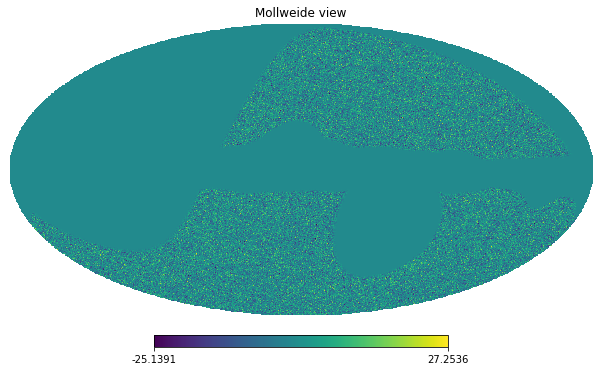

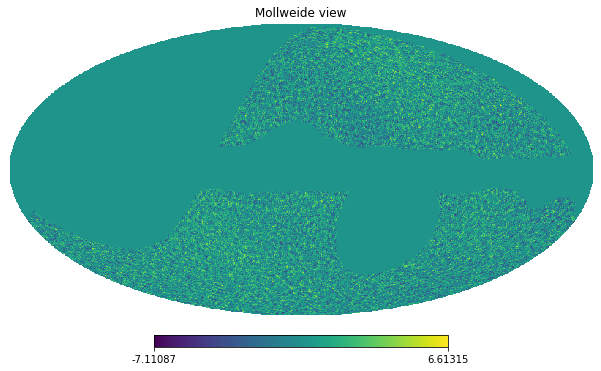

In [68]:
hp.mollview(s4map_cut*mask)
hp.mollview(hp.alm2map(lbelm,512))

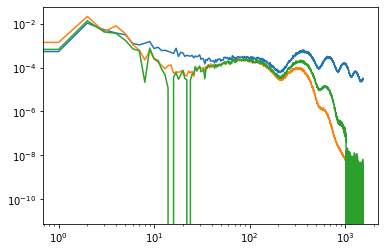

In [72]:
plt.loglog(hp.alm2cl(s4elm))
plt.loglog(hp.alm2cl(lbelm))
plt.loglog(hp.alm2cl(s4elm,lbelm))

In [9]:
mask = lb_sky.mask*hp.ud_grade(s4_sky.mask,512)

In [10]:
TQU = hp.alm2map(teb_input,512)/2.726e6 * mask
Ein,Bin = cs.utils.hp_map2alm_spin(512,1024,1024, 2, TQU[1], TQU[2])

In [12]:
dire = '/pscratch/sd/l/lonappan/LBxS4'

In [13]:
#filt = FiltCoadd(dire,lblib=lb_sky,s4lib=s4_sky,coadd=True)
#filt = FiltCoadd(dire,s4lib=s4_sky)
filt = FiltCoadd(dire,lblib=lb_sky)

INFO:LiteBIRD simulation library is loaded


In [14]:
mask_karg = {'lb_mask':lb_sky.mask,'s4_mask':s4_sky.mask}
kappa  = CoaddKappa(dire,2,1024,512,**mask_karg)

../lbxs4/utils.py:50: RuntimeWarning: invalid value encountered in true_divide
  cls[k][ell[idc]] = cols[i + 1][idc] / we[idc]
../lbxs4/multitracer.py:255: RuntimeWarning: divide by zero encountered in true_divide
  self.INls = np.array( [ 1./self.cov_n[:,:,l].diagonal() for l in range(lmax+1) ] ).T


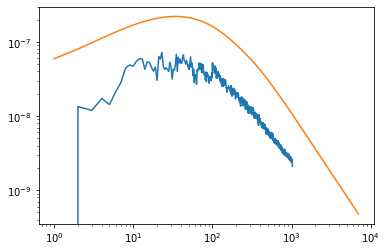

In [46]:
klm = kappa.coadd(0)
kappa.plot_coadd(0)

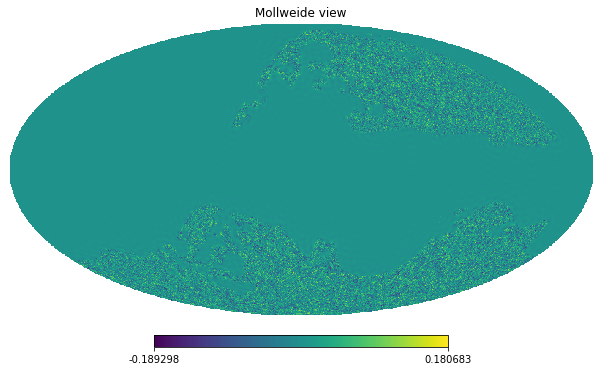

In [47]:
hp.mollview(cs.utils.hp_alm2map(512,1024,1024,klm))

In [15]:
delens = Delenser(dire,filt,kappa,)

In [16]:
lensB = delens.lensing_B(0)

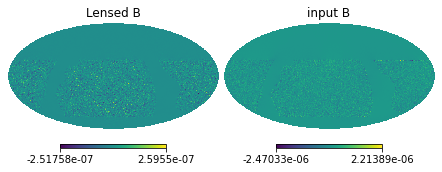

In [17]:
hp.mollview(cs.utils.hp_alm2map(512,1024,1024,lensB),sub=(1,2,1),title='Lensed B')
hp.mollview(cs.utils.hp_alm2map(512,1024,1024,Bin),sub=(1,2,2),title='input B')

In [18]:
b1 = cs.utils.alm2cl(1024,lensB)
b2 = cs.utils.alm2cl(1024,Bin)
b12 = cs.utils.alm2cl(1024,lensB,Bin)
rho = b12/np.sqrt(b1*b2)

/pscratch/sd/l/lonappan/software_pkgs/cmblens/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


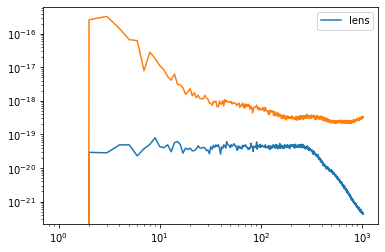

In [19]:
plt.loglog(b1, label='lens')
plt.loglog(b2)
plt.legend()

Text(0, 0.5, '$\\rho^{B_{inp}B_{temp}}$')

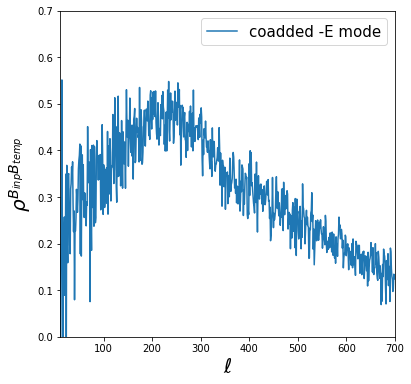

In [20]:
plt.figure(figsize=(6,6))
#plt.plot(rho,label='LB-E mode')
#plt.plot(rho1,label='S4-E mode')
plt.plot(rho,label='coadded -E mode')
plt.xlim(10,700)
plt.ylim(0,0.7)
plt.xlabel('$\ell$',fontsize=20)
plt.legend(fontsize=15)
plt.ylabel('$\\rho^{B_{inp}B_{temp}}$', fontsize=20)

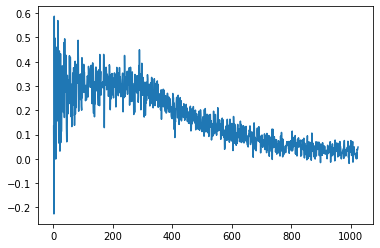

In [68]:
plt.plot(rho)